Formulaic offers several spline encoding transforms that allow you to model 
non-linear responses to continuous variables using linear models. They are:

* `poly`: projection onto orthogonal polynomial basis functions.
* `basis_spline` (`bs` in formulae): projection onto a basis spline (B-spline)
    basis.

These are all implemented as [stateful transforms](../transforms/) and described
in more detail below.

## `poly`

The simplest way to generate a non-linear response in a linear model is to 
include higher order powers of numerical variables. For example, you might want
to include: $x$, $x^2$, $x^3$, $\ldots$, $x^n$. However, these features are not 
orthogonal, and so adding each term one by one in a regression model will lead 
to all previously trained coefficients changing. Especially in exploratory 
analysis, this can be frustrating, and that's where `poly` comes in. By default,
`poly` iteratively builds orthogonal polynomial features up to the order 
specified.

`poly` has two parameters:

* **degree**: The maximum polynomial degree to generate ($degree - 1$ features 
    will thus be generated).
* **raw**: A boolean indicator of whether raw non-orthogonal polynomials should
    be generated instead of the orthogonalized ones.

For those who are mathematically inclined, this transform is an implementation
of the "three-term recurrence relation" for monic orthogonal polynomials. There
are many good introductions to these recurrence relations, including:
(at the time of writing) https://dec41.user.srcf.net/h/IB_L/numerical_analysis/2_3.
Another common approach is QR factorisation where the columns of Q are the
orthogonal basis vectors. A pre-existing implementation of this can be found in
`numpy`, however our implementation outperforms numpy's QR decomposition, and
does not require needless computation of the R matrix. It should also be noted
that orthogonal polynomial bases are unique up to the choice of inner-product
and scaling, and so all methods will result in the same set of polynomials.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        When used as a stateful transform, we retain the coefficients that
        uniquely define the polynomials; and so new data will be evaluated
        against the same polynomial bases as the original dataset. However,
        the polynomial basis will almost certainly *not* be orthogonal for the
        new data. This is because changing the incoming dataset is equivalent to
        changing your choice of inner product.
    </p>
</div>

Example:

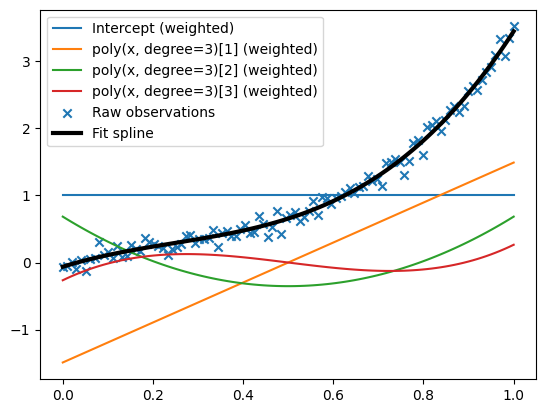

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
from statsmodels.api import OLS

from formulaic import model_matrix

# Build some data, and hard-code "y" as a quartic function with some Gaussian noise.
data = pandas.DataFrame({
    "x": numpy.linspace(0., 1., 100),
}).assign(
    y=lambda df: df.x + 0.2 * df.x**2 - 0.7 * df.x**3 + 3 * df.x**4 + 0.1 * numpy.random.randn(100)
)

# Generate a model matrix with a polynomial coding in "x".
y, X = model_matrix("y ~ poly(x, degree=3)", data, output="numpy")

# Fit coefficients for the intercept and polynomial basis
coeffs = OLS(y[:, 0], X).fit().params

# Plot the basis splines weighted by coefficients.
plt.plot(data.x, X * coeffs, label=[name + " (weighted)" for name in X.model_spec.column_names])
# Plot B-spline basis functions (colored curves) each multiplied by its coeff
plt.scatter(data.x, data.y, marker="x", label="Raw observations")
# Plot the fit spline itself (sum of the basis functions)
plt.plot(data.x, numpy.dot(X, coeffs), color='k', linewidth=3, label="Fit spline")

plt.legend();

## `basis_spline` (or `bs`)

If you were to attempt to fit a complex function over a large domain using
`poly`, it is highly likely that you would need to use a very large degree for
the polynomial basis. However, this can lead to overfitting and/or high-frequency
oscillations (see [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon)).
An alternative approach is to use piece-wise polynomial curves of lower degree,
with smoothness conditions on the "knots" between each of the polynomial pieces.
This limits overfitting while still offering the flexibility required to model
very complex non-linearities.

[Basis-splines (or B-splines)](https://en.wikipedia.org/wiki/B-spline) are 
popular choice for generating a basis for such polynomials, with many attractive
features such as maximal smoothness around each of the knots, and minimal 
support given such smoothness.

Formulaic has its own implementation of `basis_spline` that is API compatible
(where features overlap) with R, and is more performant than existing Python
implementations for our use-cases (such as `splev` from `scipy`). For 
compatibility with `R` and `patsy`, `basis_spline` is available as `bs` in
formulae.

`basis_spline` (or `bs`) has eight parameters:

* **df**: The number of degrees of freedom to use for this spline. If
    specified, `knots` will be automatically generated such that they
    are `df` - `degree` (minus one if `include_intercept` is True)
    equally spaced quantiles. You cannot specify both `df` and `knots`.
* **knots**: The internal breakpoints of the B-Spline. If not specified, they
    default to the empty list (unless `df` is specified), in which case
    the ordinary polynomial (Bezier) basis is generated.
* **degree**: The degree of the B-Spline (the highest degree of terms in the
    resulting polynomial). Must be a non-negative integer.
* **include_intercep**: Whether to return a complete (full-rank) basis. Note
    that if `ensure_full_rank=True` is passed to the materializer, then
    the intercept will (depending on context) nevertheless be omitted.
* **lower_bound**: The lower bound for the domain for the B-Spline basis. If
    not specified this is determined from `x`.
* **upper_bound**: The upper bound for the domain for the B-Spline basis. If
    not specified this is determined from `x`.
* **extrapolation**: Selects how extrapolation should be performed when values
    in `x` extend beyond the lower and upper bounds. Valid values are:
    - `'raise'` (the default): Raises a `ValueError` if there are any values in
        `x` outside the B-Spline domain.
    - `'clip'`: Any values above/below the domain are set to the
        upper/lower bounds.
    - `'na'`: Any values outside of bounds are set to `numpy.nan`.
    - `'zero'`: Any values outside of bounds are set to `0`.
    - `'extend'`: Any values outside of bounds are computed by extending
        the polynomials of the B-Spline (this is the same as the default
        in R).

The algorithm used to generate the basis splines is a slightly generalised
version of the ["Cox-de Boor" algorithm](https://en.wikipedia.org/wiki/B-spline#Definition),
extended by this author to allow for extrapolations (although this author doubts
this is terribly novel). If you would like to learn more about B-Splines, the
[primer](https://cran.r-project.org/web/packages/crs/vignettes/spline_primer.pdf)
put together by Jeffrey Racine is an excellent resource.

As a stateful transform, we only keep track of `knots`, `lower_bound` and
`upper_bound`, which are sufficient given that all other information must be
explicitly specified.

Example, reusing the data and imports from above:

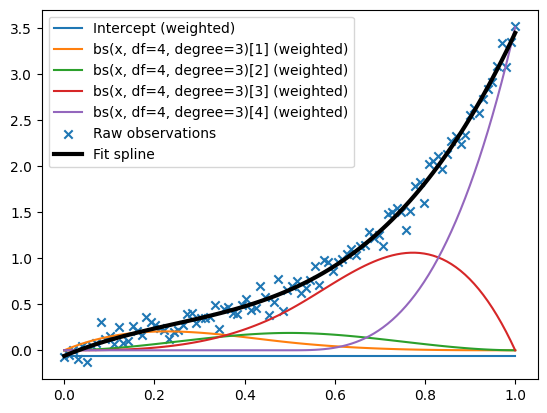

In [11]:
# Generate a model matrix with a basis spline "x".
y, X = model_matrix("y ~ bs(x, df=4, degree=3)", data, output="numpy")

# Fit coefficients for the intercept and polynomial basis
coeffs = OLS(y[:, 0], X).fit().params

# Plot the basis splines weighted by coefficients.
plt.plot(
    data.x,
    X * coeffs,
    label=[name + " (weighted)" for name in X.model_spec.column_names],
)
# Plot B-spline basis functions (colored curves) each multiplied by its coeff
plt.scatter(data.x, data.y, marker="x", label="Raw observations")
# Plot the fit spline itself (sum of the basis functions)
plt.plot(data.x, numpy.dot(X, coeffs), color="k", linewidth=3, label="Fit spline")

plt.legend();

## `cubic_spline` (`cr`/`cs` and `cc`)

While the `basis_spline` transform above is capable of generating cubic splines,
it is sometimes helpful to be able to generate cubic splines that satisfy
various additional constraints (including direct constraints on the parameters
of the spline, or indirect ones such as cyclicity). To that end, Formulaic
implements direct support for generating natural and cyclic cubic splines with
constraints (via the `cr`/`cs` and `cc` transforms respectively), borrowing much
of the implementation from `patsy`. These splines are compatible with R's
`mgcv`, and share the nice features of the basis-splines above, including
continuous first and second derivatives, and general applicability to
interpolation/smoothing. Note that `cr` and `cs` generate identical splines, but
are both included for compatibility with R.

In practice, the reason that we focus on cubic (as compared to quadratic or 
quartic) splines is that they offer a nice compromise. They offer:

1. Sufficient smoothness - Cubic splines provide smooth curves by connecting
   data points with piecewise cubic polynomials, ensuring continuity in the
   function and its first few derivatives at each connection point. 
2. Sufficient flexibility - Unlike lower-order polynomials, cubic splines can
   capture complex curves with varying curvature, making them suitable for data
   with sharp changes or multiple inflection points. Generally there is 
   diminished marginal benefit from higher order polynomials.
3. Avoids overfitting (including avoiding Runge's phenomenon described aboe) -
   Compared to higher-degree polynomials, cubic splines are less prone to large
   oscillations between data points, which can occur with high-order
   interpolation methods.

All of `cr`, `cs`, and `cc` are configurations of the `cubic_spline` transform,
and have seven parameters:

* **x**: The data to use in the spline. Depending on the other options, the knots
    are selected from this data on the first application of `cc` or `cr`. If using
    an existing `model_spec` with a fitted transformation, the `x` values are only
    used to produce the locations for the fitted values of the spline.
* **df**: The number of degrees of freedom to use for this spline. If
    specified, `knots` will be automatically generated such that they
    are `df` - `degree` equally spaced quantiles. You cannot specify both `df` and `knots`.
* **knots**: The internal breakpoints of the spline. If not specified, they
    default to the empty list (unless `df` is specified).
* **lower_bound**: The lower bound for the domain for the spline. If
    not specified this is determined from `x`.
* **upper_bound**: The upper bound for the domain for the spline. If
    not specified this is determined from `x`.
* **constraints**: Either a 2-d array defining general linear constraints
    (that is ``np.dot(constraints, betas)`` is zero, where ``betas`` denotes the
    array of *initial* parameters, corresponding to the *initial* unconstrained
    model matrix), or the string ``'center'`` indicating that we should apply a
    centering constraint (this constraint will be computed from the input data,
    remembered and re-used for prediction from the fitted model). The constraints
    are absorbed in the resulting design matrix which means that the model is
    actually rewritten in terms of *unconstrained* parameters.
* **extrapolation**: Selects how extrapolation should be performed when values
    in `x` extend beyond the lower and upper bounds. Valid values are:
    - `'raise'` (the default): Raises a `ValueError` if there are any values in
        `x` outside the spline domain.
    - `'clip'`: Any values above/below the domain are set to the
        upper/lower bounds.
    - `'na'`: Any values outside of bounds are set to `numpy.nan`.
    - `'zero'`: Any values outside of bounds are set to `0`.
    - `'extend'`: Any values outside of bounds are computed by extending
        the polynomials of the spline (this is the same as the default
        in R).

As a stateful transform, we only keep track of `knots`, `lower_bound`,
`upper_bound`, `constraints`, and `cyclic` which are sufficient given that
all other information must be explicitly specified.

Example, reusing the data and imports from above:

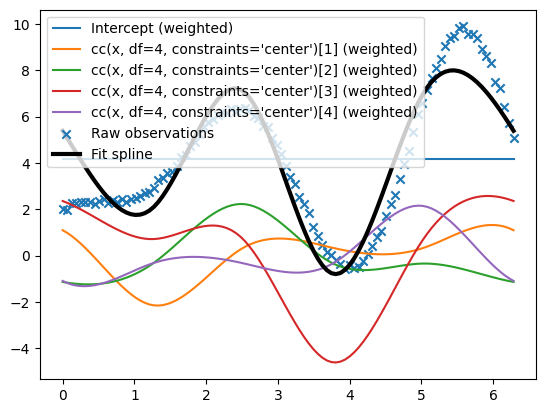

In [18]:
x = numpy.linspace(0.0, 2 * numpy.pi, 100)

data = pandas.DataFrame(
    {
        "x": x,
    }
).assign(
    y=lambda df: 2
    + numpy.sin(x)
    - x * numpy.sin(2 * x)
    + 4 * numpy.sin(x / 7)
    + 0.1 * numpy.random.randn(100)
)

# Generate a model matrix with a cyclic cubic spline coding in "x".
y, X = model_matrix("y ~ 1 + cc(x, df=4, constraints='center')", data, output="numpy")

# Fit coefficients for the intercept and polynomial basis
coeffs = OLS(y[:, 0], X).fit().params

# Plot the basis splines weighted by coefficients.
plt.plot(
    data.x,
    X * coeffs,
    label=[name + " (weighted)" for name in X.model_spec.column_names],
)
# Plot B-spline basis functions (colored curves) each multiplied by its coeff
plt.scatter(data.x, data.y, marker="x", label="Raw observations")
# Plot the fit spline itself (sum of the basis functions)
plt.plot(data.x, numpy.dot(X, coeffs), color="k", linewidth=3, label="Fit spline")

plt.legend();